### Parameters

Global variables go here:

In [48]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

image_file = "maze_1.JPG"



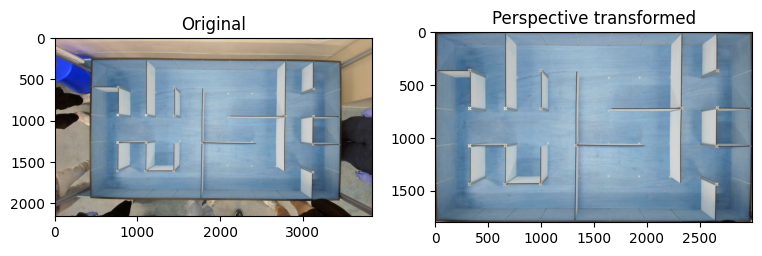

In [49]:
# read in the image
image = cv2.imread(image_file)
# plt.imshow(image)
# plt.show()

# Image transform to square it up
# [x,y]
top_left = [430, 250]
top_right = [3460, 280]
bottom_left = [420, 1950]
bottom_right = [3460, 1970]

og_corners = np.float32([top_left, top_right, bottom_left, bottom_right])

new_top_left = [0, 0]
new_top_right = [3000, 0]
new_bottom_left = [0, 1800]
new_bottom_right = [3000, 1800]
new_corners = np.float32([new_top_left, new_top_right, new_bottom_left, new_bottom_right])

rotation_matrix = cv2.getPerspectiveTransform(og_corners, new_corners)

# Apply the perspective transform
squared_image = cv2.warpPerspective(image, rotation_matrix, (3000, 1800))

fig, (ax1, ax2) = plt.subplots(figsize = (9,5), ncols = 2)
ax1.imshow(image, cmap = 'gray'), ax1.set_title("Original")
ax2.imshow(squared_image, cmap = 'gray'), ax2.set_title("Perspective transformed")
plt.show()

# cv2.imwrite('squared_image.jpg', squared_image)



#### Image Manipulation
This section is for getting the image in a format where the path planning can commence.

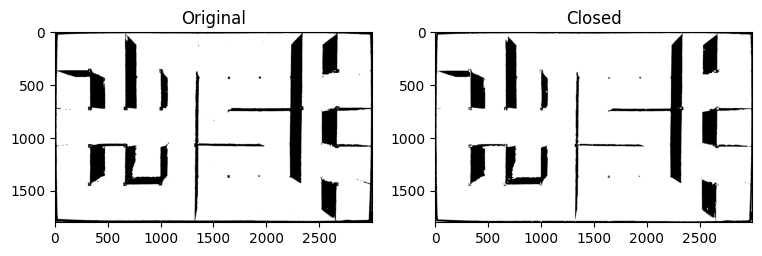

In [50]:
# determine HSV Ranges
# low_H = 9 #/179
# high_H = 71 #/179
# low_S = 2 #/255
# high_S = 152 #/255
# low_V = 101 #/255
# high_V = 231 #/255

low_H = 0 #/179
high_H = 98 #/179
low_S = 38 #/255
high_S = 180 #/255
low_V = 84 #/255
high_V = 255 #/255

#convert source image to HSV color mode
hsv_image = cv2.cvtColor(squared_image, cv2.COLOR_BGR2HSV)

#define the range for HSV values
hsv_low = np.array([low_H, low_S, low_V], np.uint8)
hsv_high = np.array([high_H, high_S, high_V], np.uint8)

#create mask for the specified HSV range
hsv_mask = cv2.inRange(hsv_image, hsv_low, hsv_high)

# masking HSV value selected color becomes black
maze_mask = cv2.cvtColor(hsv_mask, cv2.COLOR_GRAY2BGR)

# Homography
# closing_kernel = np.ones((5,5), np.uint8)
# closed_image = cv2.morphologyEx(maze_mask, cv2.MORPH_CLOSE, closing_kernel)

dilation= np.ones((4,4), np.uint8) # kernel size 3
closed_image = cv2.dilate(maze_mask, dilation, iterations = 2)

erosion = np.ones((2,2), np.uint8) # kernel size 3
closed_image = cv2.erode(closed_image, erosion, iterations = 2)

fig, (ax1, ax2) = plt.subplots(figsize = (9,5), ncols = 2)
ax1.imshow(maze_mask, cmap = 'gray'), ax1.set_title("Original")
ax2.imshow(closed_image, cmap = 'gray'), ax2.set_title("Closed")
plt.show()

#### Path Planning - Graph Class

The image is satisfactory for making a graph to plan the path and solve it. 

In [51]:
# Task 2.1 (3 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y): # the x,y is to mimic if it was on a grid
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        

    # Add a node to the graph if it doesn't already exist
    def add_node(self, node_id, x, y):
        # if the node_id is not a key already, make a node and store it with that key
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
        
            # Empty edges dict for the node
            self.edges[node_id] = {}

            
    # Function comment from lab07
    # First checks if both nodes are in the node list
    # Adds a weighted edge between two nodes identified by their ids
    def add_edge(self, node_id1, node_id2, weight):
        # check both nodes exist
        if self.node_exists(node_id1) and self.node_exists(node_id2):
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight
        
    # Function comment from lab07
    # Removes the edge between two nodes identified by their ids
    def remove_edge(self, node_id1, node_id2):
        if self.edge_exists(node_id1, node_id2):
            self.edges[node_id1].pop(node_id2, None)
            self.edges[node_id2].pop(node_id1, None) # the None stops an Value error being raised if the key isn't in the dict (the check should cover this though)
    
    # Function comment from lab07
    # Returns a list of the nodes
    def get_nodes(self):
        nodes = []
        for k,v in self.nodes.items():
            nodes.append(v)
        return nodes
    
    # Returns the edge weight between two nodes
    def get_edge_weight(self, node_id1, node_id2):
        if self.edge_exists(node_id1, node_id2):
            return self.edges[node_id1][node_id2]
        return None 
    
    # Get all the edges a node has
    def get_edges(self, node_id):
        edges = []
        node_edges = self.edges[node_id] # gets edges for a specific node
        for k,v in node_edges.items():
            edges.append(k) # add the node number, not the weight
        return edges
    
    # HELPER FUNCTION
    # Checks to see if a node is in the graph
    # returns true of false
    def node_exists(self,node_id):
        if node_id in self.edges:
            return True
        return False
    
    # HELPER FUNCTION
    # Checks to see if an edge exists between nodes
    # returns true of false
    def edge_exists(self,node_id1, node_id2):
        # Check the nodes exist
        if self.node_exists(node_id1) and self.node_exists(node_id2):
            # Then check the edge
            if node_id2 in self.edges[node_id1]:
                return True
        return False
    
    # get the coords of a node given it's ID and return the x,y as a tuple
    def get_node_coord(self,node_id):
        # Check the nodes exist
        if self.node_exists(node_id):
            return self.nodes[node_id].get_point()
        return (None, None)

### Path Planning -  Adding node grid
Similar to the indiv assignment, assigning nodes to each grid space and working out if they can be connected, and printing it out.

In [ ]:
# Given a horizontal or vertical line/space, check if more than 5 pixels are black.
# Returns True or False 
# assume x1 <= x2, and y1 <= y2
def path_clear(image, x1, y1, x2, y2):    
    # get the line, or region of interest from the image
    line = image[y1:y2, x1:x2]
    
    # count for the number of black pixel seen - ideally to avoid thinking of noise as a wall
    count = 0
    
    for x in range(x1, x2 + 1):
        for y in range(y1, y2 + 1):
            pixel = image[y,x]
            r,g,b = pixel
            # If the pixel is black
            if r == 0 and g == 0 and b == 0:
                count += 1
            if count >= 5:
                return False
    
    return True

In [ ]:

# Given an image, create a grid of nodes and connect them horizontally
# and vertically where there is not a wall. 
#
# PARAMS:
#   + image to make graph from
#   + empty graph
#
# RETURNS:
#   + graph with nodes and edges included
def create_graph_from_image(image, graph):
    ROWS = 5
    COLS = 9
    
    # Get the size of the image in pixels
    height, width, colour_channels = image.shape
    
    # divide vertical hight by n+1 grid size for vert interval
    vertical_interval = height / (ROWS + 1)
    
    # divide horizontal by n+1 grid size for width interval
    horizontal_interval = width / (COLS + 1)
    
    ## PICK UP FROM HERE
    
    # 2d loop going along a row first before going down
    # keep a count of the node number
    node_id_counter = 0
    
    for row in range(1, size_of_node_grid + 1):
        y_pixel = row * vertical_interval # we go down the y vals
        
        for col in range(1, size_of_node_grid + 1): # we love a row,col moment. 
            x_pixel = col * horizontal_interval
            
            # add the node to the graph - round the pixels as you cannot have fractions of pixels
            graph.add_node(node_id_counter, round(x_pixel), round(y_pixel))
            
            node_id_counter += 1
    
    # Go through all the nodes and add any edges that are not hindered by an obstacle. 
    for node_id in range(0, size_of_node_grid * size_of_node_grid):
        
        # get node to right and connect if it exists and is clear
        if not is_east_edge(size_of_node_grid, node_id):
            east_node = node_id + 1
            # If the path is clear, add a line w bidirectional weight
            graph = add_bi_dir_edge(image, graph, node_id, east_node)
            
        
        # get node below and connect if it exists and is clear
        if not is_south_edge(size_of_node_grid, node_id):
            south_node = node_id + size_of_node_grid
            graph = add_bi_dir_edge(image, graph, node_id, south_node)
    
    return graph


# HELPER FUNCTION
# Determine if a node is on the right most odge of the graph
def is_east_edge(grid_size, node_id):
    if node_id % grid_size == 9:
        return True
    return False

# HELPER FUNCTION
# Determine if a node is on the bottom most odge of the graph
def is_south_edge(grid_size, node_id):
    if node_id >= (grid_size * (grid_size - 1)):
        return True
    return False

# Add the nodes and their notation to the image. Deface it. Go on. 
# Will be passed an image that has been read with cv2.
def deface_image(image, graph):
    GREEN = (0,255,0)
    DARK_GREEN = (0,125,0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    
    
    plt.imshow(image)
    # for each node in the graph, place it, label it, and then loop through 
    #it's edges and draw them in
    all_nodes = graph.get_nodes()
    for node in all_nodes:
        # draw a green dot and a label for the node
        x,y = graph.get_node_coord(node.get_ID())
        cv2.circle(image,(x,y), 3, GREEN, -1)
        if node.get_ID() == 0 or node.get_ID() == ((size_of_node_grid * size_of_node_grid) - 1):
            cv2.putText(image, str(node.get_ID()), (x,y), FONT, 0.75, GREEN, 2, cv2.LINE_AA)
        
        
        # Get all the edges connected to a node
        node_edges = graph.get_edges(node.get_ID())        
        for neighbour_node in node_edges:
            xn,yn = graph.get_node_coord(neighbour_node)
            cv2.line(image, (x,y), (xn, yn), DARK_GREEN, 1)
    
    return image

### Task 0

Print Hello world to the terminal 

In [5]:
# Put your solution in this box and run the program
print("Hello world")

Hello world


### Task 1 - Load an Image

Load in the "shapes.png" image and display it using matplotlib. 

Ensure the colours are correctly displayed in RGB. [Hint](https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html#ga4e0972be5de079fed4e3a10e24ef5ef0) 

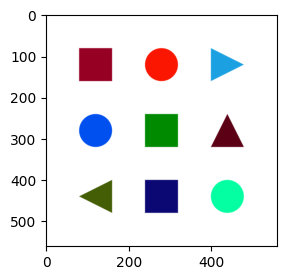

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "shapes.png"

# Read in image and convert to rgb
img = cv2.imread(IMAGE_FILE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (3,3)) # scale of the image
plt.imshow(img_rgb)
plt.show() # actually display it


### Task 2 - Colour Mask

Using a blue color mask, generate a monochrome mask of the blue shapes. 

You will need to use the cv2.inRange() function. 

Hint: ([0,0,90] and [150,180,255])






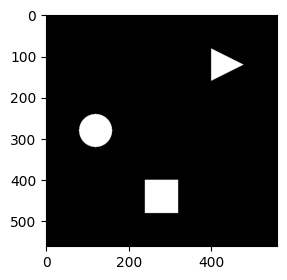

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "shapes.png"

img = cv2.imread(IMAGE_FILE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lower = np.array([0,0,90])
upper = np.array([150,180,255])

blue_mask = cv2.inRange(img_rgb, lower, upper) # a mask of colours between this rgb range

# Convert grayscale image to color image for displaying simultaneous
greyscale_shapes = cv2.cvtColor(blue_mask, cv2.COLOR_GRAY2BGR)

plt.figure(figsize = (3,3)) # scale of the image
plt.imshow(greyscale_shapes)
plt.show() # actually display it


### Task 3 - Bitwise Operation

Using the bitwise and operation, apply the mask to the source image and display the result. 

Examples for cv2.bitwise_and can be found [Here](https://www.geeksforgeeks.org/arithmetic-operations-on-images-using-opencv-set-2-bitwise-operations-on-binary-images/) 

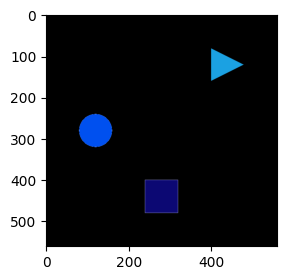

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "shapes.png"

img = cv2.imread(IMAGE_FILE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lower = np.array([0,0,90])
upper = np.array([150,180,255])

blue_mask = cv2.inRange(img_rgb, lower, upper) # a mask of colours between this rgb range
blue_shapes = cv2.bitwise_and(img_rgb, img_rgb, mask=blue_mask)

plt.figure(figsize = (3,3)) # scale of the image
plt.imshow(blue_shapes)
plt.show() # actually display it




### Task 4 - HSV and Maze

HSV (Hue, Saturation, Value) may provide better results for the Micromouse maze. 

Use the provided "hsv_picker.ipynb" to find a good range of HSV values for the maze and display the resulting mask of the maze walls. 

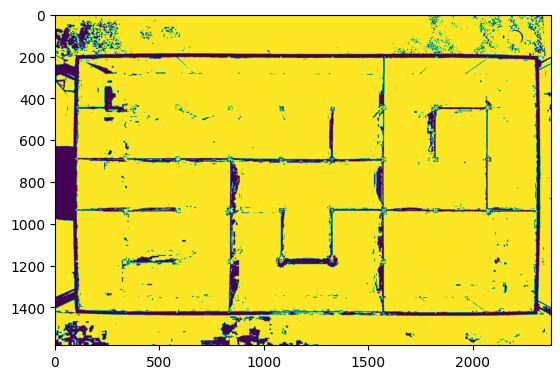

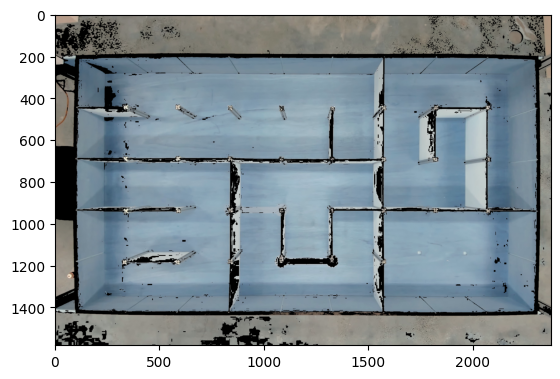

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "maze.jpg"

img = cv2.imread(IMAGE_FILE)

#convert source image to HSV color mode
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#define the range for HSV values
hsv_low = np.array([15, 8, 108], np.uint8)
hsv_high = np.array([179,255,255], np.uint8)

#create mask for the specified HSV range
mask = cv2.inRange(hsv, hsv_low, hsv_high)
#masking HSV value selected color becomes black
res = cv2.bitwise_and(img, img, mask=mask)

#show images
plt.figure()
plt.imshow(mask)
plt.show()

plt.figure()
plt.imshow(res)
plt.show()



### Task 5 - Erode

Perform an erode operation from the source image. Use a kernel size of 7 and perform 5 iterations. 

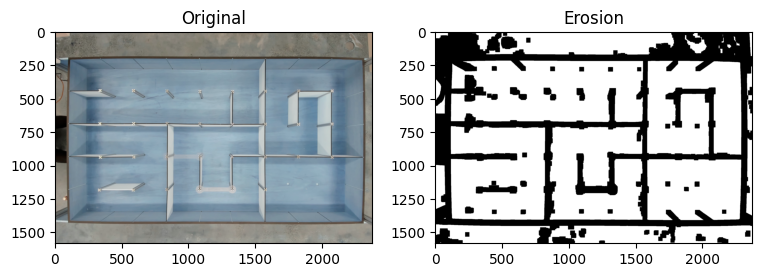

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "maze.jpg"

# GET THE MASK
#convert source image to HSV color mode
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#define the range for HSV values
# hsv_low = np.array([15, 8, 108], np.uint8)
# hsv_high = np.array([179,255,255], np.uint8)
hsv_low = np.array([0, 6, 110], np.uint8)
hsv_high = np.array([179,143,210], np.uint8)

#create mask for the specified HSV range
mask = cv2.inRange(hsv, hsv_low, hsv_high)

# ERODE THE MASK
kernel = np.ones((7,7), np.uint8) # kernel size 7
erosion = cv2.erode(mask, kernel, iterations = 5)

fig, (ax1, ax2) = plt.subplots(figsize = (9,5), ncols = 2)
ax1.imshow(img, cmap = 'gray'), ax1.set_title("Original")
ax2.imshow(erosion, cmap = 'gray'), ax2.set_title("Erosion")

# plt.imshow(erosion)
# plt.title('Erosion')
plt.show()



### Task 6 - Dilate

Perform an dilate operation from the source image. Use a kernel size of 3 and perform 5 iterations. 

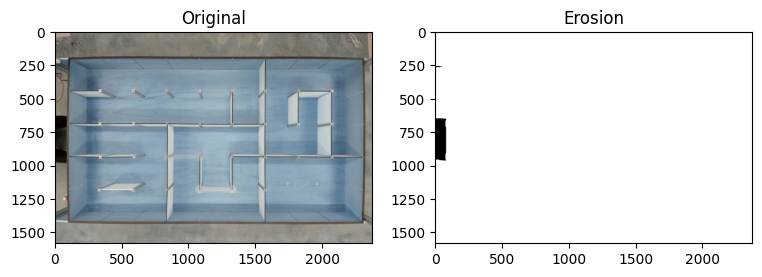

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "maze.jpg"

# GET THE MASK
#convert source image to HSV color mode
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#define the range for HSV values
# hsv_low = np.array([15, 8, 108], np.uint8)
# hsv_high = np.array([179,255,255], np.uint8)
hsv_low = np.array([0, 6, 110], np.uint8)
hsv_high = np.array([179,143,210], np.uint8)

#create mask for the specified HSV range
mask = cv2.inRange(hsv, hsv_low, hsv_high)

# ERODE THE MASK
dilation= np.ones((2,2), np.uint8) # kernel size 3
dilation = cv2.dilate(mask, kernel, iterations = 5)

fig, (ax1, ax2) = plt.subplots(figsize = (9,5), ncols = 2)
ax1.imshow(img, cmap = 'gray'), ax1.set_title("Original")
ax2.imshow(dilation, cmap = 'gray'), ax2.set_title("Erosion")

# plt.imshow(erosion)
# plt.title('Erosion')
plt.show()





### Task 7 - ASCII representation

Note: This task should be completed as it is part of the Micromouse assignment

Convert the maze into an ASCII representation shown in the lab document. You may need to perform a series of erosions and dilations to get a good mask. 

Hint: Write a generic function to sample pixels between two coordinates. 


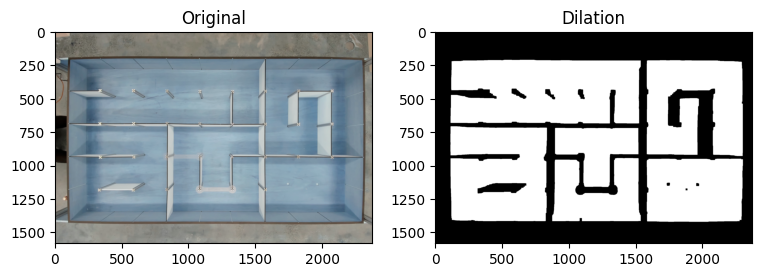

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FILE = "maze.jpg"

# GET THE MASK
#convert source image to HSV color mode
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#define the range for HSV values
# hsv_low = np.array([15, 8, 108], np.uint8)
# hsv_high = np.array([179,255,255], np.uint8)
# hsv_low = np.array([0, 6, 110], np.uint8)
# hsv_high = np.array([179,143,210], np.uint8)
hsv_low = np.array([12, 32, 0], np.uint8)
hsv_high = np.array([72,255,215], np.uint8)

#create mask for the specified HSV range
mask = cv2.inRange(hsv, hsv_low, hsv_high)

# ERODE THE MASK
kernel = np.ones((7,7), np.uint8) # kernel size 7
erosion = cv2.erode(mask, kernel, iterations = 9)

# OPENING
kernel = np.ones((8,8), np.uint8)
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)

# DILATE 
dilation= np.ones((7,7), np.uint8) # kernel size 3
dilation = cv2.dilate(closing, kernel, iterations = 6)

fig, (ax1, ax2) = plt.subplots(figsize = (9,5), ncols = 2)
ax1.imshow(img, cmap = 'gray'), ax1.set_title("Original")
ax2.imshow(dilation, cmap = 'gray'), ax2.set_title("Dilation")
plt.show()
